In [395]:
import os
import numpy as np
import random
import torch
import time
import optuna
from train_dqn import fill_memory, train_dqn
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [396]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [397]:
from envs.GraphEnv.impnode import ImpnodeEnv
import DQN_agent_modular

In [398]:
# variables for training the agent

num_train_eps = 3000 #10000 number training episodes to run
num_mem_fill_eps = 500#1000 number of episodes to run to initialize the memory
discount = 0.99 # gamma used for computing return
batch_size = 64 # number of transitions to sample from replay buffer for each learn step
mem_capacity = 1500  # 500000 size of the memory buffer
update_frequency = 100 #1000 number of interactions after which the target buffer is updated
eps_max = 1.0 # initial epsilon value
eps_min = 0.05 # final epsilon value
eps_step = 100 #1000 amount by which epsilon is decayed at each episode
lr = 0.001 # learning rate for the network
alpha = 0.001 # weighing factor for graph reconstruction loss

gnn_depth=4
state_size=2
hidden_size1=32
hidden_size2=64
action_size=1
n_step=3

ba_nodes = (30, 50)
ba_edges=4
anc = 'dw_nd'
max_removed_nodes = None
seed = None


In [399]:
results_base_path_train = "results/{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                           device, alpha, num_train_eps, num_mem_fill_eps, discount, batch_size, mem_capacity, update_frequency, eps_max, eps_min, eps_step, lr, gnn_depth, state_size, hidden_size1, hidden_size2, action_size, n_step, ba_nodes, ba_edges, anc, max_removed_nodes, seed)

if not os.path.exists(results_base_path_train):
    os.makedirs(results_base_path_train)
else:
    timestamp = time.strftime("%Y%m%d%H%M%S")
    new_directory = f"{results_base_path_train}_{timestamp}"
    os.makedirs(new_directory)
    results_base_path_train = new_directory
    print(f"Directory already exists. Created a new one: {new_directory}")



Directory already exists. Created a new one: results/cuda_0.001_3000_500_0.99_64_1500_100_1.0_0.05_100_0.001_4_2_32_64_1_3_(30, 50)_4_dw_nd_None_None_20240404151903


In [400]:
env_train = ImpnodeEnv(anc=anc, 
                       ba_nodes=ba_nodes, 
                       ba_edges=ba_edges,
                       seed=seed, 
                       render_option=False, 
                       mode='train',
                       max_removed_nodes=max_removed_nodes)

In [401]:
# create the dqn_agent
dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                             alpha=alpha,
                                             gnn_depth=gnn_depth,
                                             state_size=state_size,
                                             hidden_size1=hidden_size1,
                                             hidden_size2=hidden_size2,
                                             action_size=action_size,
                                             discount=discount,
                                             eps_max=eps_max,
                                             eps_min=eps_min,
                                             eps_step=eps_step,
                                             memory_capacity=mem_capacity,
                                             lr=lr,
                                             mode='train')



In [402]:
fill_memory(env_train, dqn_agent_train, num_mem_fill_eps, n_step)


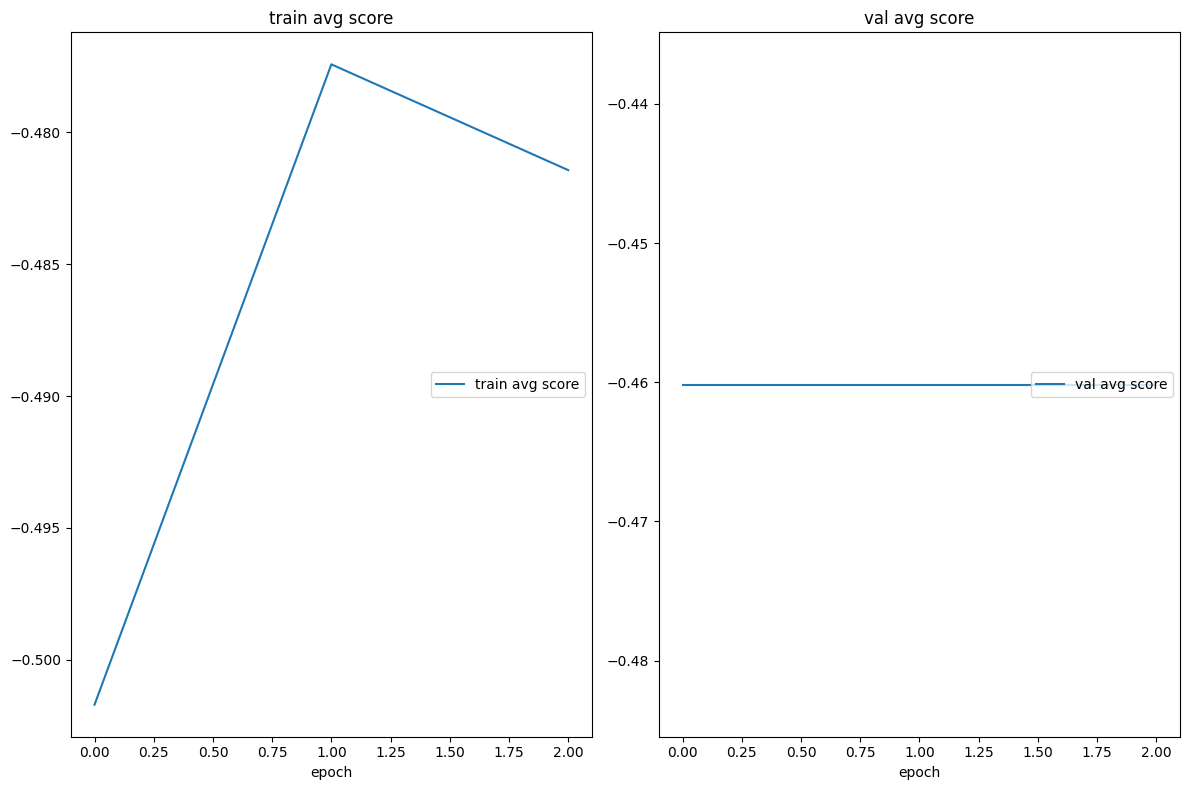

train avg score
	train avg score  	 (min:   -0.502, max:   -0.477, cur:   -0.481)
val avg score
	val avg score    	 (min:   -0.460, max:   -0.460, cur:   -0.460)


KeyboardInterrupt: 

In [403]:
train_dqn(env_train, dqn_agent_train, results_base_path_train, num_train_eps, n_step, batch_size, update_frequency)


In [ ]:
print('done')

# visualize train and val performance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
out = pd.read_csv('{}/info.csv'.format(results_base_path_train))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.set_ylabel('episode')
ax1.set_xlabel('train avg score')
ax2.set_xlabel('val avg score')
ax1.plot(out.ep_cnt, out.train_avg_score)
ax2.plot(out.ep_cnt, out.val_avg_score)